In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [5]:
raw_type_list = ['User_ID', 'Gender', 'Age', 'Occupation', 'Star_Sign', 'Date', 'Text']
top_word_list = ['anyways', 'cuz', 'digest', 'diva', 'evermean', 'fox', 'gonna', 'greg', 'haha', 'jayel',
                 'kinda', 'levengals', 'literacy', 'lol', 'melissa', 'nan', 'nat', 'postcount', 'ppl', 'rick',
                 'school', 'shep', 'sherry', 'spanners', 'teri', 'u', 'ur', 'urllink', 'wanna', 'work']
top_type_list = ['Instance_ID'] + top_word_list + ['Class']
raw_file_dict = {'train': 'train_raw.csv', 'dev': 'dev_raw.csv', 'test': 'test_raw.csv'}
top_file_dict = {'train': 'train_top10.csv', 'dev': 'dev_top10.csv', 'test': 'test_top10.csv'}

In [6]:
def read_raw_data(file_name):
    if 'raw' in file_name:
        input_data = pd.read_csv(file_name, names=raw_type_list)
    else:
        input_data = pd.read_csv(file_name, names=top_type_list)
    # df = pd.DataFrame({'Age': input_data['Age'], 'Text': input_data['Text']})
    return input_data

In [7]:
def convert_class(raw):
    if raw == '14-16': return 0
    elif raw == '24-26': return 1
    elif raw == '34-36': return 2
    elif raw == '44-46': return 3

def convert_dict(file_name):
    X = []
    y = []
    f = open(file_name, 'r')
    for line in f:
        atts = line[:-1].split(",")
        this = {}
        count = 1
        for type in top_word_list:
            this[type] = int(atts[count])
            count += 1
        if atts[-1] != '?':
            X.append(this)
            y.append(convert_class(atts[-1]))
    f.close()
    return X, y

In [8]:
from sklearn.feature_extraction import DictVectorizer

file_name = top_file_dict['train']
data_train = read_raw_data(file_name)
X_train = data_train.iloc[:, 1:-1]
y_train = data_train.iloc[:, -1]
# X, y_train = convert_dict(file_name)
# vec = DictVectorizer()
# X_train = vec.fit_transform(X).toarray()

file_name = top_file_dict['dev']
data_test = read_raw_data(file_name)
X_test = data_test.iloc[:, 1:-1]
y_test = data_test.iloc[:, -1]
# X, y_test = convert_dict(file_name)
# vec = DictVectorizer()
# X_test = vec.fit_transform(X).toarray()

In [9]:
# Zero R - 38% / 51%
from sklearn.dummy import DummyClassifier
zero_r = DummyClassifier(strategy='most_frequent')
zero_r.fit(X_train, y_train)
print("Zero-R:", accuracy_score(zero_r.predict(X_test), y_test))
# cross_val_score(zero_r, X, y, cv=10)

Zero-R: 0.3815847524927204


In [10]:
# Decision Tree - 43% / 58%
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=None)
dt.fit(X_train, y_train)
print("Decision Tree:", dt.score(X_test, y_test))

Decision Tree: 0.4330053825112503


In [ ]:
# Prediction from test data

file_name = top_file_dict['test']
data_train = read_raw_data(file_name)
index = data_train.iloc[:, 0]
X_pred = data_train.iloc[:, 1:-1]
y_pred = dt.predict(X_pred)

df = pd.DataFrame()
df['Id'] = index
df['Prediction'] = y_pred
df.to_csv('out.csv', sep=',')

In [ ]:
# KNN - %
# from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=3)
# neigh.fit(X_train, y_train)
# print("KNN:", neigh.score(X_test, y_test))

In [ ]:
# Linear SVC - %
# from sklearn.svm import LinearSVC
# clf = LinearSVC(random_state=0)
# clf.fit(X_train, y_train)
# print("LinearSVC:", clf.score(X_test, y_test))

In [ ]:
# SVC - 
# from sklearn.svm import SVC
# clf = SVC()
# clf.fit(X_train, y_train)
# print("SVC:", clf.score(X_test, y_test))

In [ ]:
# Logistic Regression - 42% / 57%
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)
print("Logistic:", clf.score(X_test, y_test))

In [ ]:
# Age distributions of top 30 words
word_dict = {'anyways': {'14-16': 6268, '24-26': 2887, '34-36': 185, '44-46': 14},
             'cuz': {'14-16': 7991, '24-26': 1945, '34-36': 377, '44-46': 9},
             'digest': {'14-16': 37, '24-26': 106, '34-36': 1147, '44-46': 4},
             'diva': {'14-16': 33, '24-26': 172, '34-36': 631, '44-46': 0},
             'evermean': {'14-16': 0, '24-26': 0, '34-36': 259, '44-46': 0},
             'fox': {'14-16': 303, '24-26': 684, '34-36': 171, '44-46': 783},
             'gonna': {'14-16': 15897, '24-26': 6463, '34-36': 644, '44-46': 237},
             'greg': {'14-16': 241, '24-26': 691, '34-36': 159, '44-46': 528},
             'haha': {'14-16': 12247, '24-26': 1721, '34-36': 75, '44-46': 5},
             'jayel': {'14-16': 0, '24-26': 0, '34-36': 0, '44-46': 161},
             'kinda': {'14-16': 8676, '24-26': 4271, '34-36': 368, '44-46': 128},
             'levengals': {'14-16': 0, '24-26': 0, '34-36': 0, '44-46': 163},
             'literacy': {'14-16': 12, '24-26': 112, '34-36': 535, '44-46': 7},
             'lol': {'14-16': 17475, '24-26': 2195, '34-36': 542, '44-46': 873},
             'melissa': {'14-16': 371, '24-26': 356, '34-36': 24, '44-46': 276},
             'nan': {'14-16': 108, '24-26': 115, '34-36': 10, '44-46': 159},
             'nat': {'14-16': 264, '24-26': 97, '34-36': 2, '44-46': 225},
             'postcount': {'14-16': 0, '24-26': 356, '34-36': 389, '44-46': 0},
             'ppl': {'14-16': 5155, '24-26': 791, '34-36': 54, '44-46': 0},
             'rick': {'14-16': 164, '24-26': 513, '34-36': 229, '44-46': 945},
             'school': {'14-16': 21845, '24-26': 13784, '34-36': 3026, '44-46': 667},
             'shep': {'14-16': 3, '24-26': 0, '34-36': 2, '44-46': 310},
             'sherry': {'14-16': 17, '24-26': 54, '34-36': 16, '44-46': 195},
             'spanners': {'14-16': 0, '24-26': 1, '34-36': 104, '44-46': 0},
             'teri': {'14-16': 14, '24-26': 14, '34-36': 3, '44-46': 108},
             'u': {'14-16': 24316, '24-26': 5753, '34-36': 329, '44-46': 61},
             'ur': {'14-16': 4854, '24-26': 873, '34-36': 21, '44-46': 1},
             'urllink': {'14-16': 29240, '24-26': 93701, '34-36': 24976, '44-46': 4465},
             'wanna': {'14-16': 8377, '24-26': 2986, '34-36': 268, '44-46': 54},
             'work': {'14-16': 13242, '24-26': 40902, '34-36': 8489, '44-46': 1807}}

for k, v in word_dict.items():
    print(v)
    plt.bar(range(len(v)), list(v.values()), align='center')
    plt.xticks(range(len(v)), list(v.keys()))
    plt.title(k)
    plt.show()

In [ ]:
# Multinomial NB - 43% / 58%
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
print("MultinomialNB:", clf.score(X_test, y_test))

In [ ]:
# Gaussian NB - 41% / 56%
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
print("GaussianNB:", clf.score(X_test, y_test))

In [ ]:
import re

def convert_digit(raw):
    if raw in range(14, 17): return 0
    elif raw in range(24, 27): return 1
    elif raw in range(34, 37): return 2
    elif raw in range(44, 47): return 3

data = pd.read_csv("train_raw.csv", names=raw_type_list)
# text_nopunc = []
X = []
y = []
for index, text in data.iterrows():
    if index > 1000:
        break
    nopunc = re.sub(r'[^a-zA-Z0-9 ]', '', text['Text'])
    X.append(len(set(nopunc.split())))
    y.append(convert_digit(text['Age']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [1]:
from pattern.en import lemma

print(lemma('working'))

work


Optimal number of features : 28


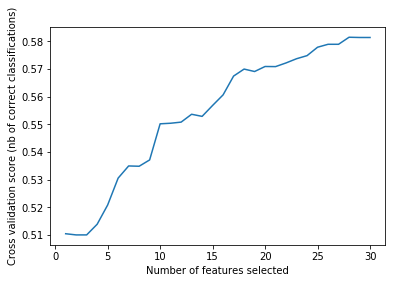

In [11]:
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.naive_bayes import MultinomialNB

# Build a classification task using 3 informative features
# Create the RFE object and compute a cross-validated score.
clf = LinearSVC(C=1.0)
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()